# INF442 Project: Power Consumption Weather
<span style="color:green">Students: </span> *Huu Nguyen Hoang, Gabriel Pereira de Carvalho*

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Python setup](#setup)
- [Task 1: Data preprocessing](#1)
    - [Creating two principal dataframes](#1.1)
    - [Treating missing data](#1.2)
        - [Visualising the missing data](#1.2.1)
        - [Interpolating missing data](#1.2.2)
        - [Winsorizing outliers](#1.2.3)
- [Task 2: Seasonality detection](#2)
- [Task 3: Distribution of hourly consumption](#3)
- [Task 4: Using station data to predict energy consumption](#4)

<h2 align="center"> <font color='gray'>Python setup</font></h2> <a class="anchor" id="setup"></a>

In [130]:
!pip install -q numpy pandas missingno datetime seaborn matplotlib scipy kneed

import numpy as np
import pandas as pd
import missingno as msno
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, kstest

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

<h2 align="center"> <font color='gray'>Task 1: Data preprocessing</font></h2> <a class="anchor" id="1"></a>

<h3 align="center"> <font color='gray'>Creating two principal dataframes</font></h3> <a class="anchor" id="1.1"></a>

Our data folder has four *csv* files with data relative to the household. To facilitate our analysis, we will convert the *csv* files containing data from the household into a single dataframe.

In [2]:
df_2007 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2007.csv',  sep=';')
df_2007.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

df_2008 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2008.csv',  sep=';')
df_2008.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

df_2009 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2009.csv',  sep=';')
df_2009.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

df_2010 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2010.csv',  sep=';')
df_2010.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

#to facilitate preprocessing, we will concatenate the dataframes
df_list = [df_2007, df_2008, df_2009, df_2010]
df_household = pd.concat(df_list)

/tmp/ipykernel_248839/3375055808.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2007 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2007.csv',  sep=';')
/tmp/ipykernel_248839/3375055808.py:4: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2008 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2008.csv',  sep=';')
/tmp/ipykernel_248839/3375055808.py:7: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2009 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2009.csv',  sep=';')
/tmp/ipykernel_248839/3375055808.py:10: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2010 = pd.read_csv('p1-power-weather/hous

We have a dataframe with all data collected relative to the household. First, let's convert all dates to **DateTime** and all the numeric data from object data-type to float/int data-type:

In [3]:
df_household['date'] = pd.to_datetime(df_household['Date'] + ' ' + df_household['Time'], format='%d/%m/%Y %H:%M:%S')
df_household.drop(['Date', 'Time'], axis=1, inplace=True)

In [4]:
df_household.replace('?', np.nan, inplace=True)

df_household['global_active_power'] = df_household['global_active_power'].astype('float')
df_household['global_reactive_power'] = df_household['global_reactive_power'].astype('float')
df_household['voltage'] = df_household['voltage'].astype('float')
df_household['global_intensity'] = df_household['global_intensity'].astype('float')
df_household['sub_metering_1'] = df_household['sub_metering_1'].astype('float')
df_household['sub_metering_2'] = df_household['sub_metering_2'].astype('float')
df_household['sub_metering_3'] = df_household['sub_metering_3'].astype('float')

df_household.describe(include='all')

global_active_power  global_reactive_power       voltage  \
count         2.027284e+06           2.027284e+06  2.027284e+06   
mean          1.082831e+00           1.236313e-01  2.408333e+02   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           5.940000e-01           1.000000e-01  2.410000e+02   
75%           1.520000e+00           1.940000e-01  2.428700e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   
std           1.049284e+00           1.126387e-01  3.231264e+00   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  \
count      2.027284e+06    2.027284e+06    2.027284e+06    2.027284e+06   
mean       4.590848e+00    1.120551e+00    1.288581e+00    6.448125e+00   
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00   
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00   
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00   
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01   
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01   
std        4.410805e+00    6.147376e+00    5.786211e+00    8.434116e+00   

                                date  
count                        2053259  
mean   2008-12-13 22:31:27.762031104  
min              2007-01-01 00:01:00  
25%              2007-12-23 11:15:30  
50%              2008-12-13 22:31:00  
75%              2009-12-05 09:46:30  
max              2010-11-26 21:02:00  
std                              NaN

Now we must repeat this procedure for the data relative to the weather stations. In fact, we will need an additional step because we must filter only the data relative to the *Orly* station which is pertinent to the household.

In [5]:
csv_file_names = [
    'synop.200701.csv', 'synop.200702.csv', 'synop.200703.csv', 'synop.200704.csv', 'synop.200705.csv', 'synop.200706.csv',
    'synop.200707.csv', 'synop.200708.csv', 'synop.200709.csv', 'synop.200710.csv', 'synop.200711.csv', 'synop.200712.csv',
    'synop.200801.csv', 'synop.200802.csv', 'synop.200803.csv', 'synop.200804.csv', 'synop.200805.csv', 'synop.200806.csv',
    'synop.200807.csv', 'synop.200808.csv', 'synop.200809.csv', 'synop.200810.csv', 'synop.200811.csv', 'synop.200812.csv',
    'synop.200901.csv', 'synop.200902.csv', 'synop.200903.csv', 'synop.200904.csv', 'synop.200905.csv', 'synop.200906.csv',
    'synop.200907.csv', 'synop.200908.csv', 'synop.200909.csv', 'synop.200910.csv', 'synop.200911.csv', 'synop.200912.csv',
    'synop.201001.csv', 'synop.201002.csv', 'synop.201003.csv', 'synop.201004.csv', 'synop.201005.csv', 'synop.201006.csv',
    'synop.201007.csv', 'synop.201008.csv', 'synop.201009.csv', 'synop.201010.csv', 'synop.201011.csv', 'synop.201012.csv']

df_list = []
for csv_file_name in csv_file_names:
    dataframe_i = pd.read_csv('p1-power-weather/weather/' + csv_file_name,  sep=';')
    df_list.append(dataframe_i)

df_station = pd.concat(df_list)

In [6]:
#We keep only data relative to Orly station
df_station = df_station[df_station.numer_sta == 7149]
#we can now delete the numer_sta column
df_station.drop(['numer_sta'], axis=1, inplace=True)

In order to manipulate our dataframes in the next sections, we need to correctly type each column and make sure that missing data is represented by *Not a number* values across the dataframes.

In [7]:
df_station['date'] = pd.to_datetime(df_station['date'], format='%Y%m%d%H%M%S')

df_station.replace('?', np.nan, inplace=True)
df_station.replace('mq', np.nan, inplace=True)

#pmer;tend;cod_tend;dd;ff;t;td;u;vv;ww;w1;w2;n;nbas;hbas;cl;cm;ch;pres;niv_bar;geop;tend24;tn12;tn24;tx12;tx24;tminsol;sw;tw;raf10;
#rafper;per;etat_sol;ht_neige;ssfrai;perssfrai;
#rr1;rr3;rr6;rr12;rr24;phenspe1;phenspe2;phenspe3;phenspe4;nnuage1;ctype1;hnuage1;nnuage2;ctype2;hnuage2;nnuage3;ctype3;hnuage3;nnuage4;ctype4;hnuage4;
df_station['pmer'] = df_station['pmer'].astype('float')
df_station['tend'] = df_station['tend'].astype('float')
df_station['cod_tend'] = df_station['cod_tend'].astype('float')
df_station['dd'] = df_station['dd'].astype('float')
df_station['ff'] = df_station['ff'].astype('float')
df_station['t'] = df_station['t'].astype('float')
df_station['td'] = df_station['td'].astype('float')
df_station['u'] = df_station['u'].astype('float')
df_station['vv'] = df_station['vv'].astype('float')
df_station['ww'] = df_station['ww'].astype('float')
df_station['w1'] = df_station['w1'].astype('float')
df_station['w2'] = df_station['w2'].astype('float')
df_station['n'] = df_station['n'].astype('float')
df_station['nbas'] = df_station['nbas'].astype('float')
df_station['hbas'] = df_station['hbas'].astype('float')
df_station['cl'] = df_station['cl'].astype('float')
df_station['cm'] = df_station['cm'].astype('float')
df_station['ch'] = df_station['ch'].astype('float')
df_station['pres'] = df_station['pres'].astype('float')
df_station['niv_bar'] = df_station['niv_bar'].astype('float')
df_station['geop'] = df_station['geop'].astype('float')
df_station['tend24'] = df_station['tend24'].astype('float')
df_station['tn12'] = df_station['tn12'].astype('float')
df_station['tn24'] = df_station['tn24'].astype('float')
df_station['tx12'] = df_station['tx12'].astype('float')
df_station['tx24'] = df_station['tx24'].astype('float')
df_station['tminsol'] = df_station['tminsol'].astype('float')
df_station['sw'] = df_station['sw'].astype('float')
df_station['tw'] = df_station['tw'].astype('float')
df_station['raf10'] = df_station['raf10'].astype('float')
df_station['rafper'] = df_station['rafper'].astype('float')
df_station['per'] = df_station['per'].astype('float')
df_station['etat_sol'] = df_station['etat_sol'].astype('float')
df_station['ht_neige'] = df_station['ht_neige'].astype('float')
df_station['ssfrai'] = df_station['ssfrai'].astype('float')
df_station['perssfrai'] = df_station['perssfrai'].astype('float')
df_station['rr1'] = df_station['rr1'].astype('float')
df_station['rr3'] = df_station['rr3'].astype('float')
df_station['rr6'] = df_station['rr6'].astype('float')
df_station['rr12'] = df_station['rr12'].astype('float')
df_station['rr24'] = df_station['rr24'].astype('float')
df_station['phenspe1'] = df_station['phenspe1'].astype('float')
df_station['phenspe2'] = df_station['phenspe2'].astype('float')
df_station['phenspe3'] = df_station['phenspe3'].astype('float')
df_station['phenspe4'] = df_station['phenspe4'].astype('float')
df_station['nnuage1'] = df_station['nnuage1'].astype('float')
df_station['nnuage2'] = df_station['nnuage2'].astype('float')
df_station['nnuage3'] = df_station['nnuage3'].astype('float')
df_station['nnuage4'] = df_station['nnuage4'].astype('float')
df_station['ctype1'] = df_station['ctype1'].astype('float')
df_station['ctype2'] = df_station['ctype2'].astype('float')
df_station['ctype3'] = df_station['ctype3'].astype('float')
df_station['ctype4'] = df_station['ctype4'].astype('float')
df_station['hnuage1'] = df_station['hnuage1'].astype('float')
df_station['hnuage2'] = df_station['hnuage2'].astype('float')
df_station['hnuage3'] = df_station['hnuage3'].astype('float')
df_station['hnuage4'] = df_station['hnuage4'].astype('float')
df_station = df_station.drop('Unnamed: 59', axis=1)

df_station.describe(include='all')



date           pmer          tend  \
count                          11656   11649.000000  11629.000000   
mean   2008-12-31 02:18:05.312285440  101617.513091      0.216700   
min              2007-01-01 00:00:00   97090.000000  -1070.000000   
25%              2008-01-01 05:15:00  101080.000000    -70.000000   
50%              2008-12-31 04:30:00  101680.000000      0.000000   
75%              2009-12-30 18:45:00  102220.000000     70.000000   
max              2010-12-31 21:00:00  104350.000000   1240.000000   
std                              NaN     952.100837    127.399857   

           cod_tend            dd            ff             t            td  \
count  11629.000000  11653.000000  11653.000000  11649.000000  11649.000000   
mean       4.352739    186.823994      3.700781    284.657932    280.040257   
min        0.000000      0.000000      0.000000    260.750000    256.150000   
25%        2.000000     80.000000      2.100000    279.450000    276.150000   
50%        5.000000    210.000000      3.100000    284.650000    280.550000   
75%        7.000000    270.000000      5.100000    289.950000    284.350000   
max        8.000000    360.000000     15.900000    308.550000    293.650000   
std        2.716401    105.773578      2.090223      7.289477      5.687828   

                  u            vv  ...       hnuage1      nnuage2  \
count  11649.000000  11648.000000  ...  10099.000000  5821.000000   
mean      75.863679  17945.394059  ...   1815.521339     5.444082   
min       20.000000     50.000000  ...     20.000000     1.000000   
25%       64.000000  12000.000000  ...    450.000000     4.000000   
50%       80.000000  20000.000000  ...    990.000000     6.000000   
75%       90.000000  25000.000000  ...   1500.000000     7.000000   
max      100.000000  45000.000000  ...   9000.000000     8.000000   
std       17.099372   7591.628204  ...   2266.529336     1.662454   

            ctype2      hnuage2      nnuage3       ctype3      hnuage3  \
count  5821.000000  5821.000000  1267.000000  1267.000000  1267.000000   
mean      4.461605  2673.617935     6.315706     3.362273  3689.881610   
min       0.000000    30.000000     1.000000     0.000000    90.000000   
25%       3.000000   750.000000     6.000000     0.000000  1350.000000   
50%       6.000000  1500.000000     7.000000     3.000000  3000.000000   
75%       6.000000  3000.000000     7.000000     6.000000  7500.000000   
max       9.000000  7800.000000     8.000000     9.000000  7800.000000   
std       2.690529  2688.856769     1.109245     2.714818  2798.758482   

         nnuage4     ctype4      hnuage4  
count  26.000000  26.000000    26.000000  
mean    6.269231   3.384615  3379.615385  
min     5.000000   0.000000   720.000000  
25%     5.250000   3.000000  1575.000000  
50%     6.000000   3.000000  3000.000000  
75%     7.000000   6.000000  3000.000000  
max     8.000000   6.000000  7800.000000  
std     0.961569   2.299164  2392.231562  

[8 rows x 58 columns]

<h3 align="center"> <font color='gray'>Treating missing data</font></h3> <a class="anchor" id="1.2"></a>

<h4 align="center"> <font color='gray'>Visualising the missing data</font></h4> <a class="anchor" id="1.2.1"></a>

First, let's visualise how many rows of data are missing for each column in the two dataframes.

<Axes: >

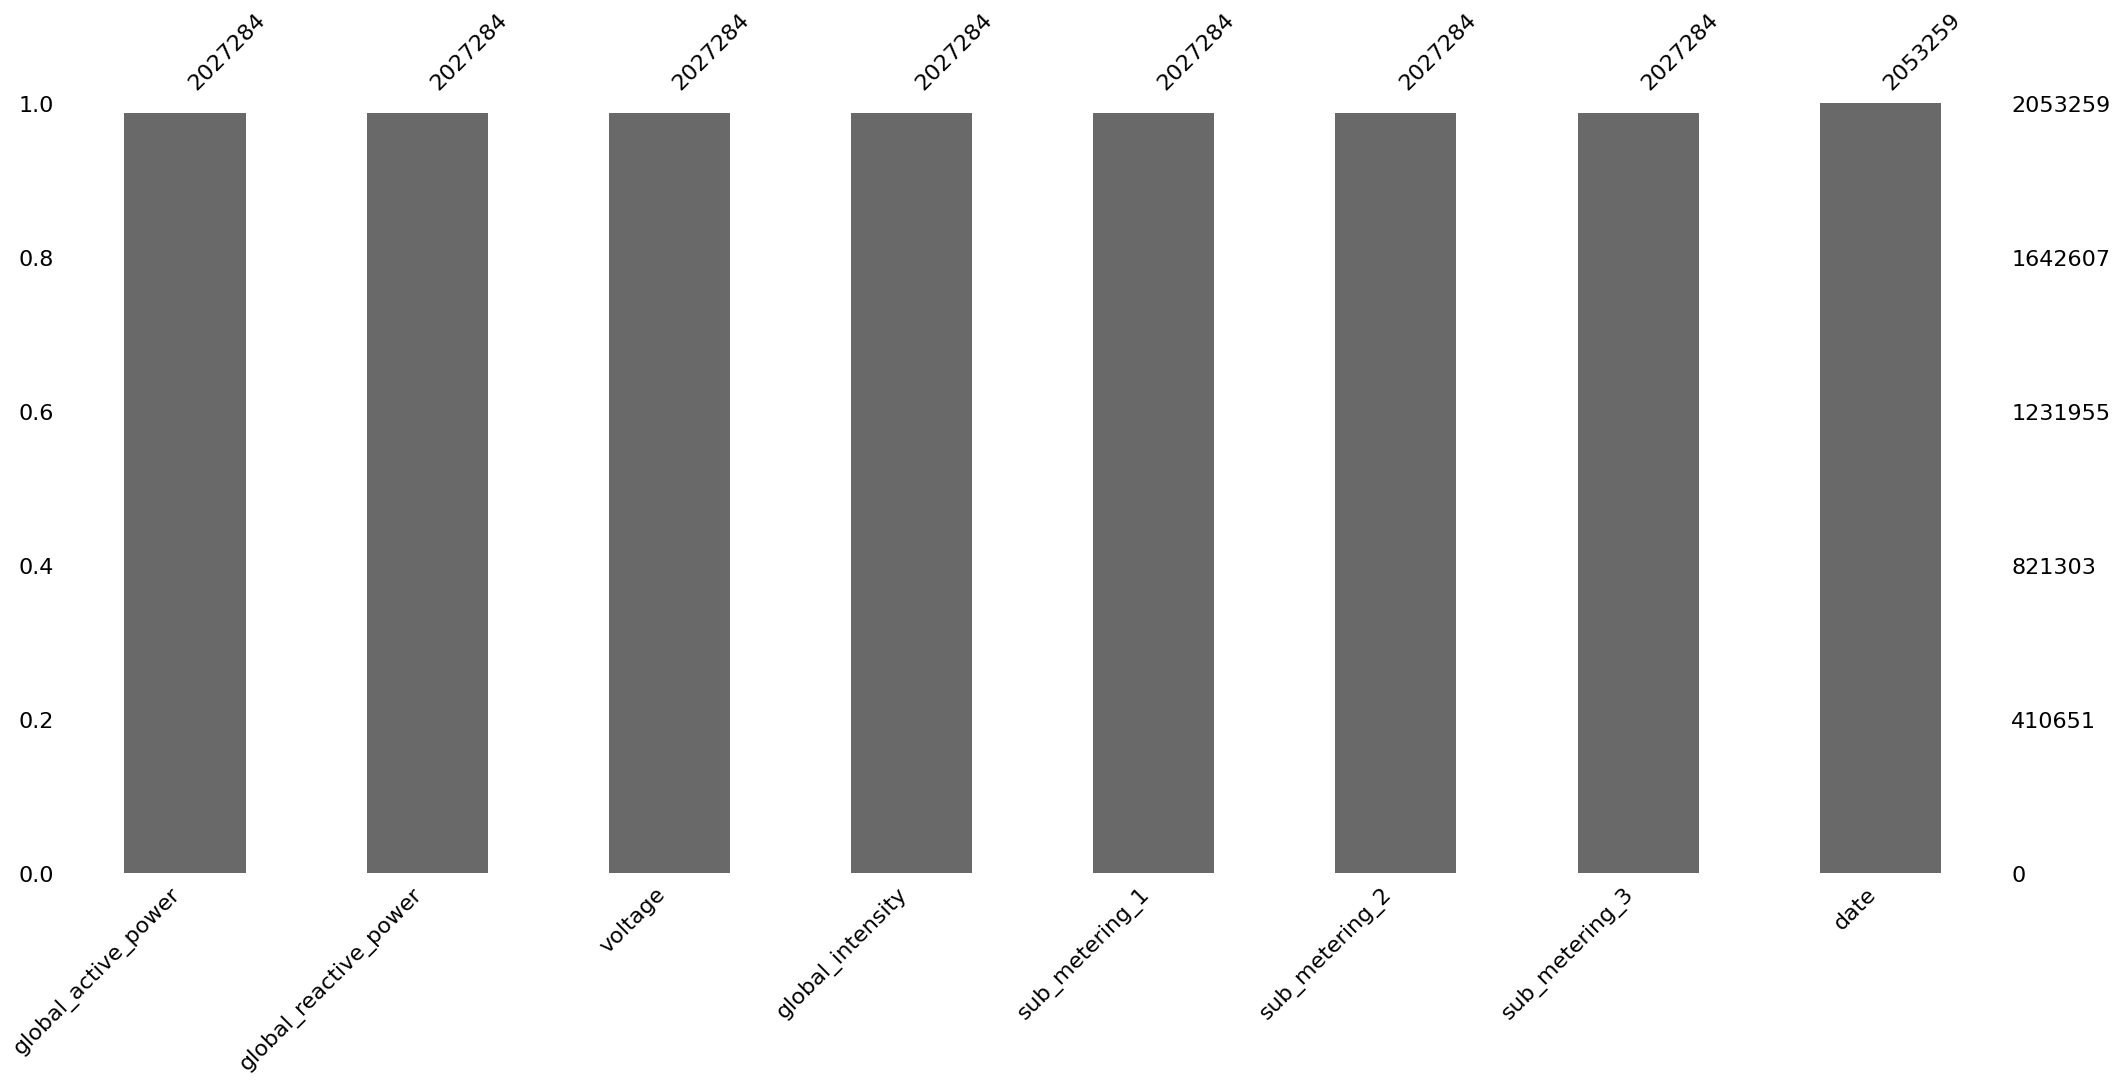

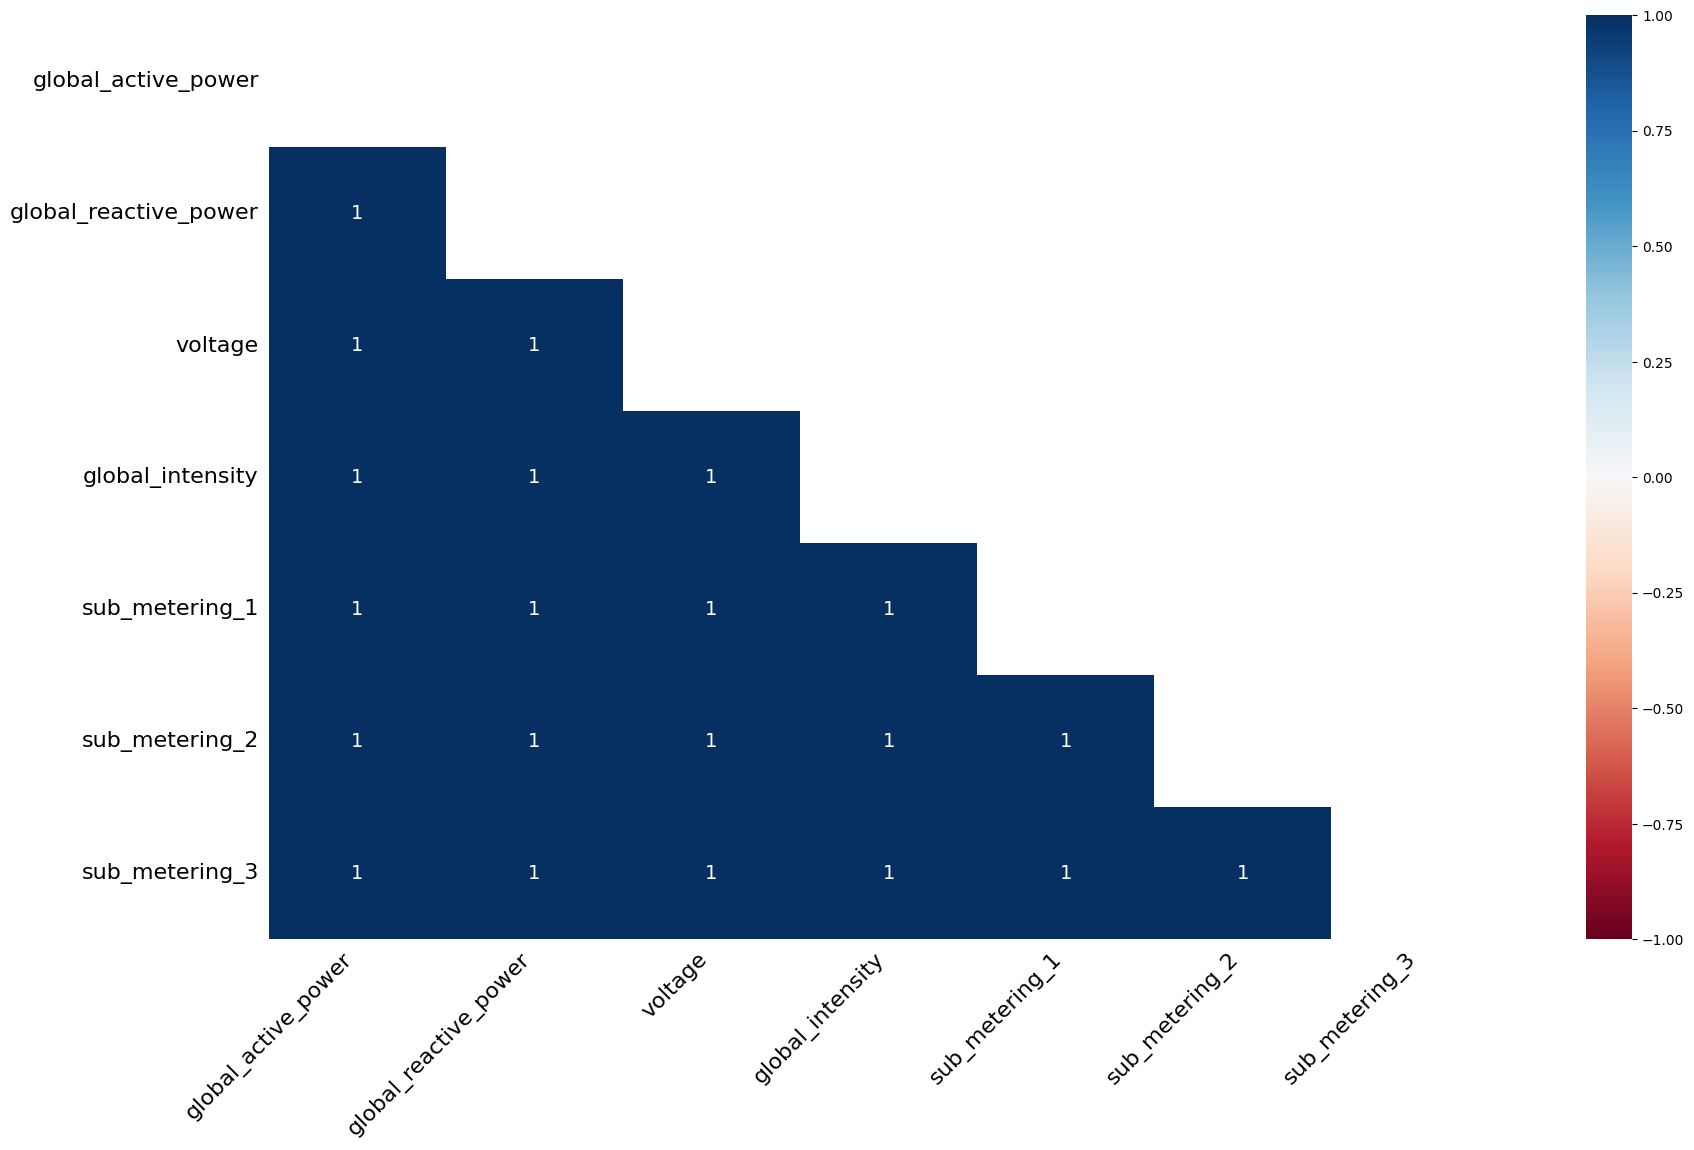

In [8]:
msno.bar(df_household)
msno.heatmap(df_household)

We observe that in the *df_household* dataframe a small percentage of the data is missing and missing values always appear as entire rows. This suggests that we can effectively interpolate missing values.

<Axes: >

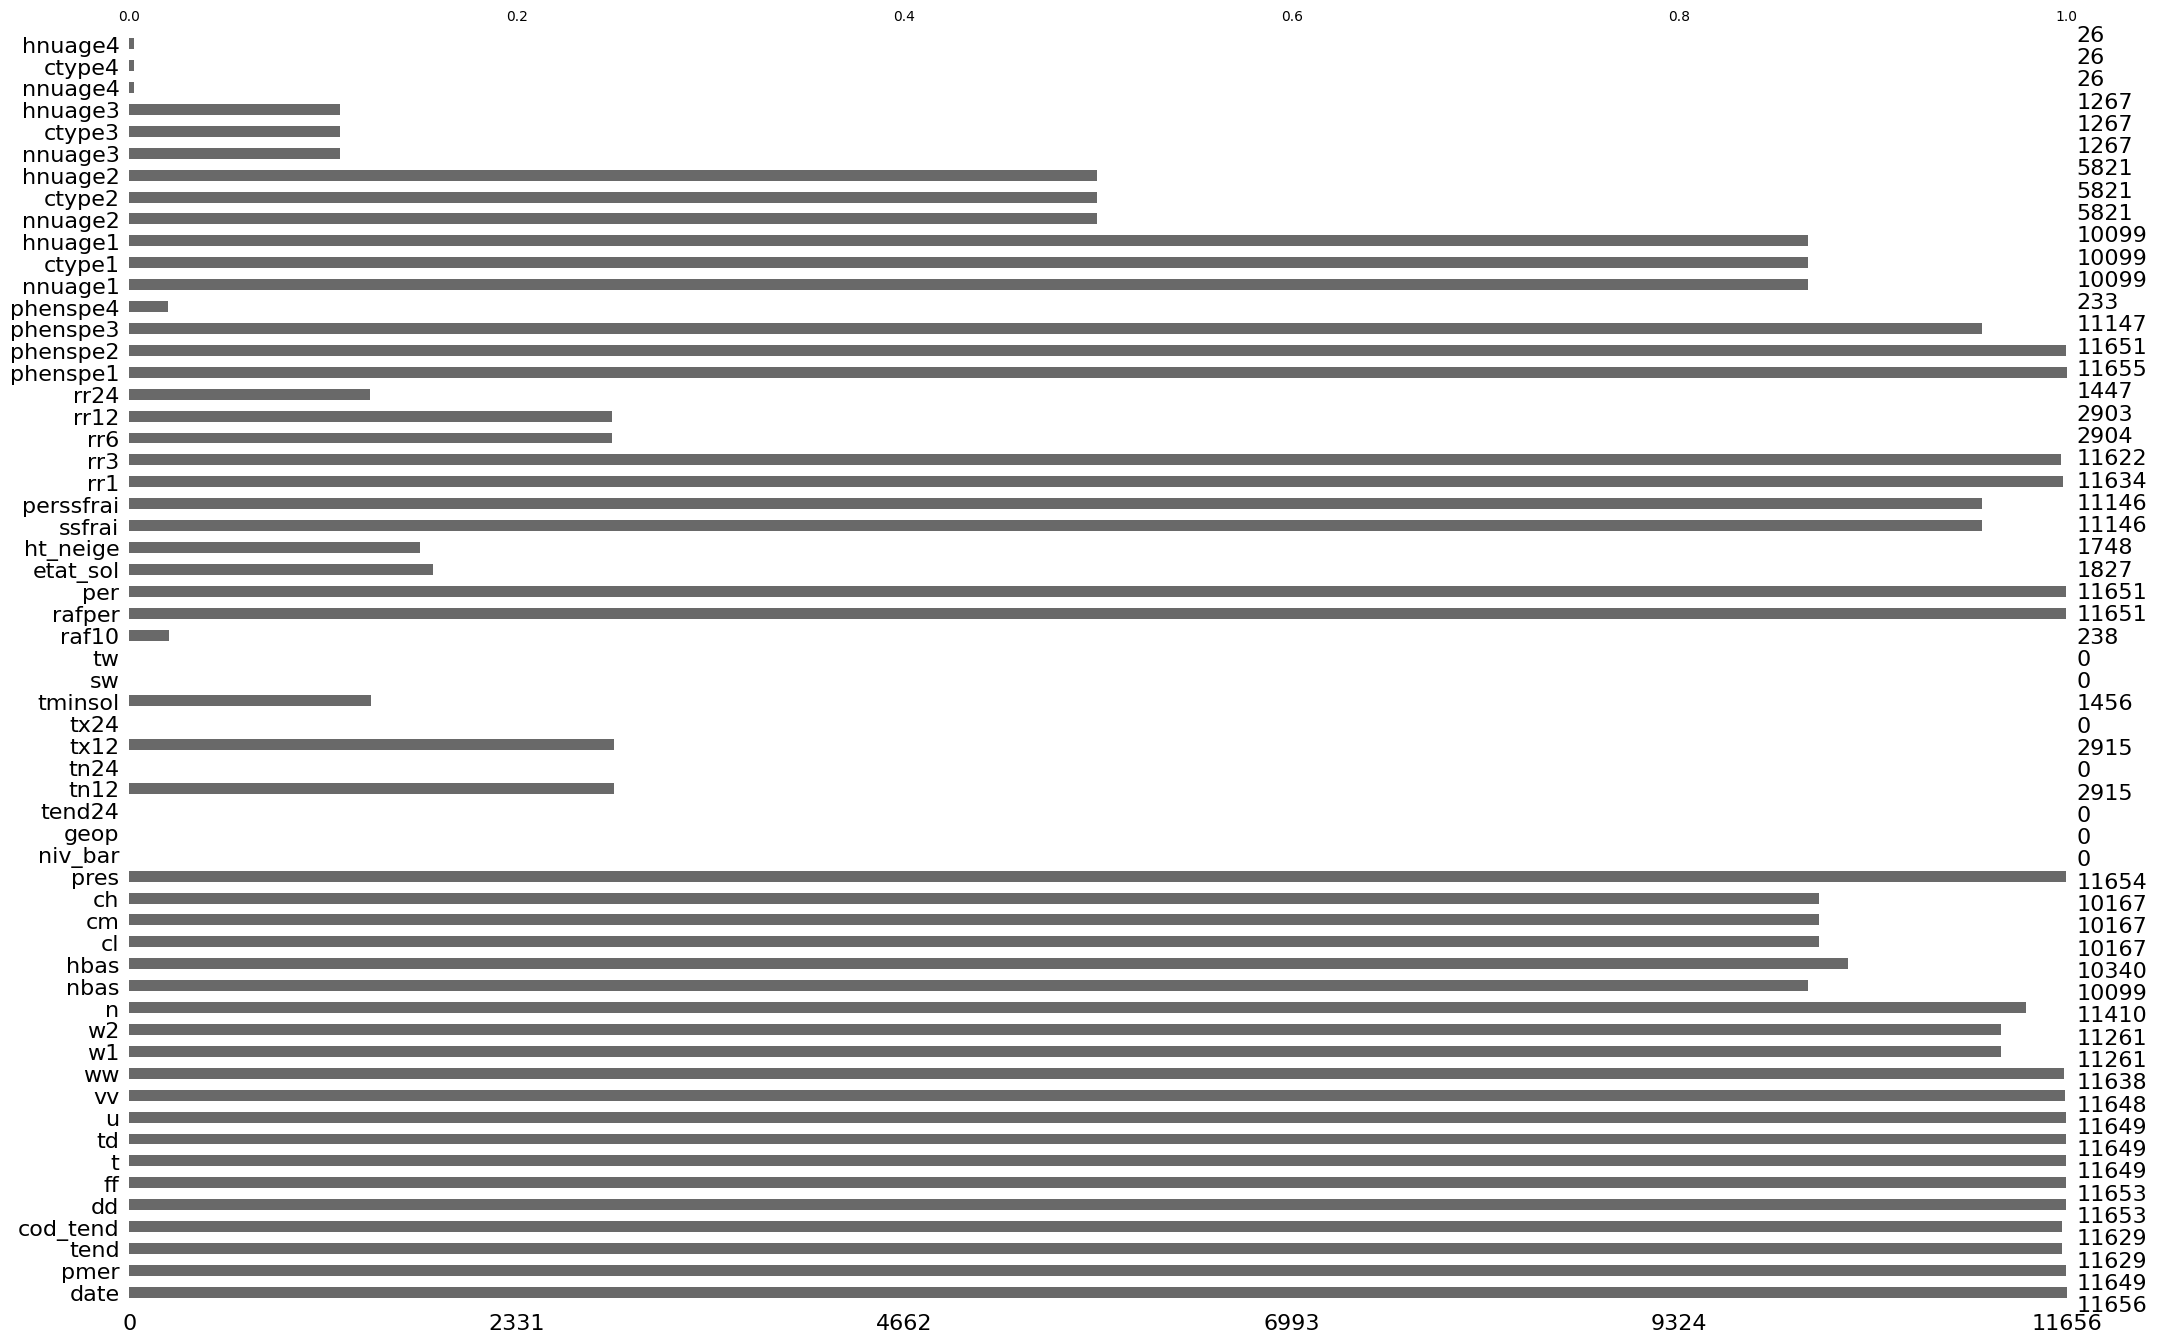

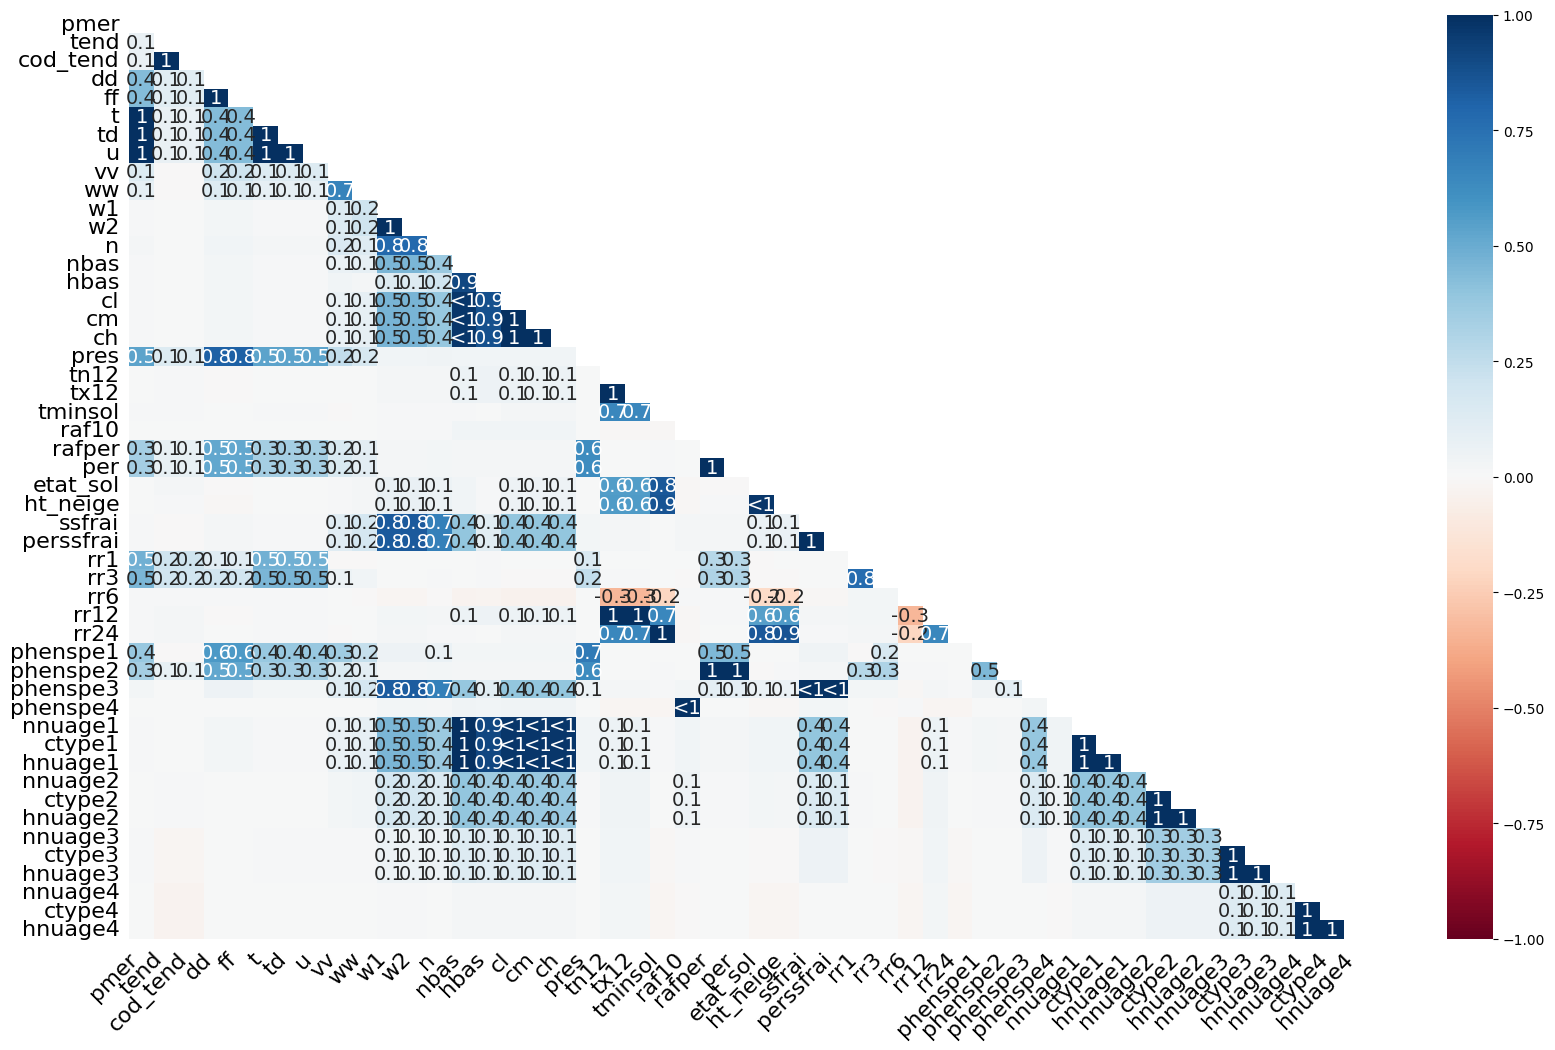

In [9]:
msno.bar(df_station)
msno.heatmap(df_station)

For the *df_station* dataset, the situation is more complicated. We have a bigger amount of missing data and missing values do not always come in blocks as indicated by the heatmap.

<h4 align="center"> <font color='gray'>Interpolating missing data</font></h4> <a class="anchor" id="1.2.2"></a>

We would like to fill rows with missing data in order to keep the structure of our data. Let's use interpolation to fill these missing values.

In [41]:
df_household = df_household.interpolate()
df_station = df_station.interpolate()
df_station = df_station.ffill()
df_station = df_station.bfill()

df_station = df_station.drop('tw', axis=1)
df_station = df_station.drop('sw', axis=1)
df_station = df_station.drop('tx24', axis=1)
df_station = df_station.drop('tn24', axis=1)
df_station = df_station.drop('tend24', axis=1)
df_station = df_station.drop('geop', axis=1)
df_station = df_station.drop('niv_bar', axis=1)

<h4 align="center"> <font color='gray'>Winsorizing outliers</font></h4> <a class="anchor" id="1.2.3"></a>

We start with the household dataset. Let's compute the **z-scores** and visualise their distribution using boxplots. 

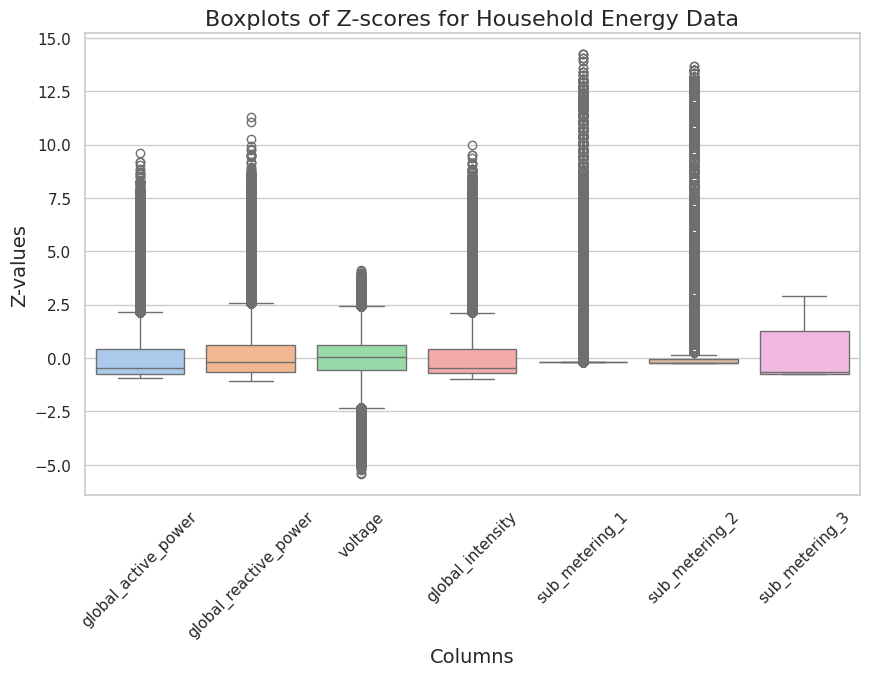

In [11]:
# Calculate Z-scores
z_scores = (df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']] - df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']].mean()) / df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']].std()

# we set the color palette for better visualisation
sns.set(style="whitegrid", palette="pastel")

# we set a convenient figure size
plt.figure(figsize=(10, 6))

# plot boxplots for Z-scores
sns.boxplot(data=z_scores, orient="v")
plt.title('Boxplots of Z-scores for Household Energy Data', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Z-values', fontsize=14)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3'], rotation=45)

plt.show()

We observe a large amount of outliers for many of the dataframe's columns. Some outliers are quite extreme and likely represent errors in the sensor data. To eliminate outliers from our dataframe, we use the *winsorization* technique. In other words, we shall fix a z-score threshold and replace values outside this threshold with a maximal/minimal value.

In [12]:
threshold = 0.997

# Replace values exceeding threshold with values at threshold percentile
df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']] = df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']].clip(lower=z_scores.quantile(1-threshold), upper=z_scores.quantile(threshold), axis=1)

In [42]:
df_station.columns

Index(['date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tn12',
       'tx12', 'tminsol', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4'],
      dtype='object')

Now, we repeat this procedure for the weather station data. Since we have a lot of Let's calculate z-scores and plot the boxplots.

In [43]:
z_scores2 = (df_station[['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tn12',
       'tx12', 'tminsol', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4']] - df_station[['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tn12',
       'tx12', 'tminsol', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4']].mean())/df_station[['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tn12',
       'tx12', 'tminsol', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4']].std()

df_station[['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tn12',
       'tx12', 'tminsol', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4']] = df_station[['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tn12',
       'tx12', 'tminsol', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4']].clip(lower=z_scores2.quantile(1-threshold), upper=z_scores2.quantile(threshold), axis=1)


<h2 align="center"> <font color='gray'>Task 2: Seasonality detection</font></h2> <a class="anchor" id="2"></a>

In [18]:
daily_energy_consumption = df_household[['date', 'global_active_power']]

daily_energy_consumption.set_index('date', inplace=True)

daily_energy_consumption = daily_energy_consumption.resample('D').sum()
daily_energy_consumption *= 60 # we convert power to energy in kJ


# Print or use the structured array
print(daily_energy_consumption)

            global_active_power
date                           
2007-01-01        164785.440000
2007-01-02         76154.160000
2007-01-03         60744.703121
2007-01-04        192239.508657
2007-01-05        161831.596219
...                         ...
2010-11-22        121799.356219
2010-11-23         94649.308747
2010-11-24        107623.418109
2010-11-25         85841.354374
2010-11-26         89286.240000

[1426 rows x 1 columns]


In [19]:
# Reset the index to move 'date' back into a regular column
daily_energy_consumption.reset_index(inplace=True)

# Convert the 'date' column to datetime format if it's not already
daily_energy_consumption['date'] = pd.to_datetime(daily_energy_consumption['date'])

# Extract the day of the year and assign it to the 'date' column
daily_energy_consumption['date'] = daily_energy_consumption['date'].dt.dayofyear

# Print the entire DataFrame
print(daily_energy_consumption.to_string(index=False))


 date  global_active_power
    1        164785.440000
    2         76154.160000
    3         60744.703121
    4        192239.508657
    5        161831.596219
    6         89429.591208
    7        139361.387336
    8        134459.354374
    9        108950.185581
   10        127086.654328
   11        131565.318064
   12         87285.011868
   13        176094.398498
   14        176283.559249
   15        128603.589362
   16        100978.749362
   17        167277.044306
   18        108874.120615
   19         88548.834989
   20        180533.699864
   21        187588.833487
   22        128301.078064
   23        105952.288087
   24        177282.339955
   25         95141.812483
   26         97046.068747
   27        120806.065581
   28        182020.877404
   29        118785.995604
   30        101064.505581
   31        140143.830592
   32        108721.350592
   33         99997.468747
   34        230336.600434
   35        209837.546106
   36         98022.625581
 

In [20]:
scaler = StandardScaler()
scaled_daily_energy_consumption = scaler.fit_transform(daily_energy_consumption)

In [21]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(scaled_daily_energy_consumption)

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

We will use the Elbow method to determine the optimal number of clusters.

/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' 

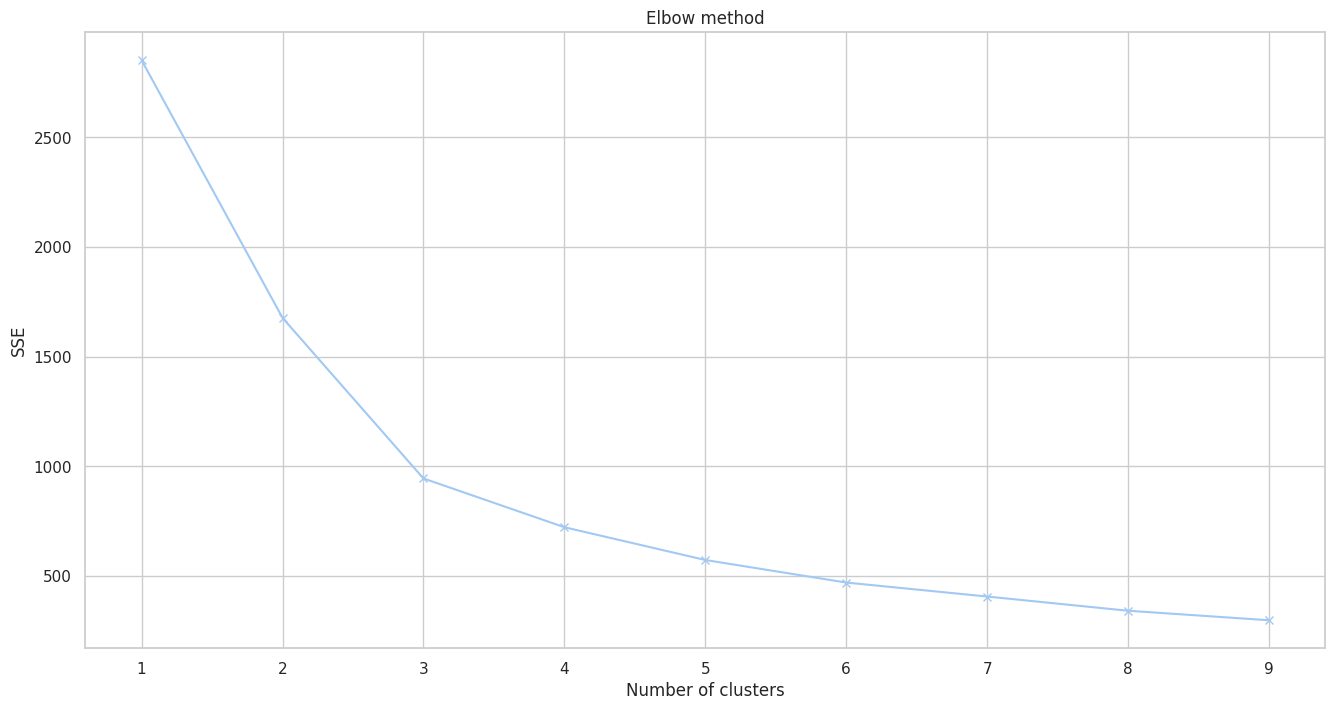

In [22]:
sse = []
k_vals = range(1,10)
for k in k_vals:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled_daily_energy_consumption)
    sse.append(kmeanModel.inertia_)
# Plotting the distortions
plt.figure(figsize=(16,8))
plt.plot(k_vals, sse, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow method")
plt.show()

In [23]:
kl = KneeLocator(k_vals, sse, curve="convex", direction="decreasing")

print(kl.elbow)

3


In [24]:
# Define the model
kmeans_model = KMeans(n_clusters=3, random_state=32932)
# Fit into our dataset fit
kmeans_predict = kmeans_model.fit_predict(scaled_daily_energy_consumption)
daily_energy_consumption['cluster'] = kmeans_predict

/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


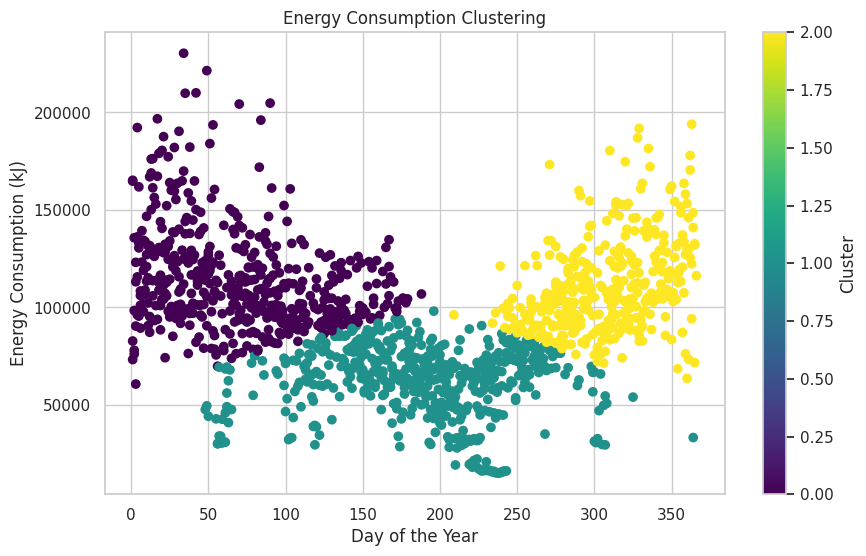

In [25]:
# Scatter plot the points in daily_energy_consumption DataFrame
plt.figure(figsize=(10, 6))
plt.scatter(daily_energy_consumption['date'], daily_energy_consumption['global_active_power'], c=kmeans_predict, cmap='viridis')
plt.title('Energy Consumption Clustering')
plt.xlabel('Day of the Year')
plt.ylabel('Energy Consumption (kJ)')
plt.colorbar(label='Cluster')
plt.show()

<h2 align="center"> <font color='gray'>Task 3: Distribution of hourly consumption</font></h2> <a class="anchor" id="3"></a>

In [26]:
hourly_energy_consumption = df_household[['date', 'global_active_power']]

hourly_energy_consumption.set_index('date', inplace=True)

hourly_energy_consumption = hourly_energy_consumption.resample('H').sum()
hourly_energy_consumption *= 60 # we convert power to energy in kJ


# Print or use the structured array
print(hourly_energy_consumption)

                     global_active_power
date                                    
2007-01-01 00:00:00              9027.48
2007-01-01 01:00:00              9084.24
2007-01-01 02:00:00              9296.40
2007-01-01 03:00:00              9150.00
2007-01-01 04:00:00              8912.64
...                                  ...
2010-11-26 17:00:00              6213.24
2010-11-26 18:00:00              5664.48
2010-11-26 19:00:00              5973.60
2010-11-26 20:00:00              4189.32
2010-11-26 21:00:00               168.24

[34222 rows x 1 columns]


In [27]:
# Reset the index to move 'date' back into a regular column
hourly_energy_consumption.reset_index(inplace=True)

# Convert the 'date' column to datetime format if it's not already
hourly_energy_consumption['date'] = pd.to_datetime(hourly_energy_consumption['date'])

# Extract the day of the year and assign it to the 'date' column
hourly_energy_consumption['hour'] = hourly_energy_consumption['date'].dt.hour

hourly_energy_consumption['day'] = hourly_energy_consumption['date'].dt.dayofyear

hourly_energy_consumption['year'] = hourly_energy_consumption['date'].dt.year


hourly_energy_consumption.set_index('date', inplace=True)

# Print the entire DataFrame
print(hourly_energy_consumption.to_string(index=False))

 global_active_power  hour  day  year
         9027.480000     0    1  2007
         9084.240000     1    1  2007
         9296.400000     2    1  2007
         9150.000000     3    1  2007
         8912.640000     4    1  2007
         8914.440000     5    1  2007
         8840.880000     6    1  2007
         8809.920000     7    1  2007
         8790.240000     8    1  2007
        11326.080000     9    1  2007
         9582.240000    10    1  2007
         9273.600000    11    1  2007
         9417.120000    12    1  2007
         7784.640000    13    1  2007
         4659.840000    14    1  2007
         6873.000000    15    1  2007
         5004.360000    16    1  2007
         5875.440000    17    1  2007
         5262.840000    18    1  2007
         2636.280000    19    1  2007
         1484.280000    20    1  2007
         1562.160000    21    1  2007
         1597.440000    22    1  2007
         1619.880000    23    1  2007
         1607.160000     0    2  2007
         157

In [28]:
# Filter the dataset for days with label 20, 200, and 340
day_20_samples = hourly_energy_consumption[(hourly_energy_consumption['day'] == 20) & (hourly_energy_consumption['year'] == 2007)]
day_200_samples = hourly_energy_consumption[(hourly_energy_consumption['day'] == 200) & (hourly_energy_consumption['year'] == 2007)]
day_340_samples = hourly_energy_consumption[(hourly_energy_consumption['day'] == 340) & (hourly_energy_consumption['year'] == 2007)]


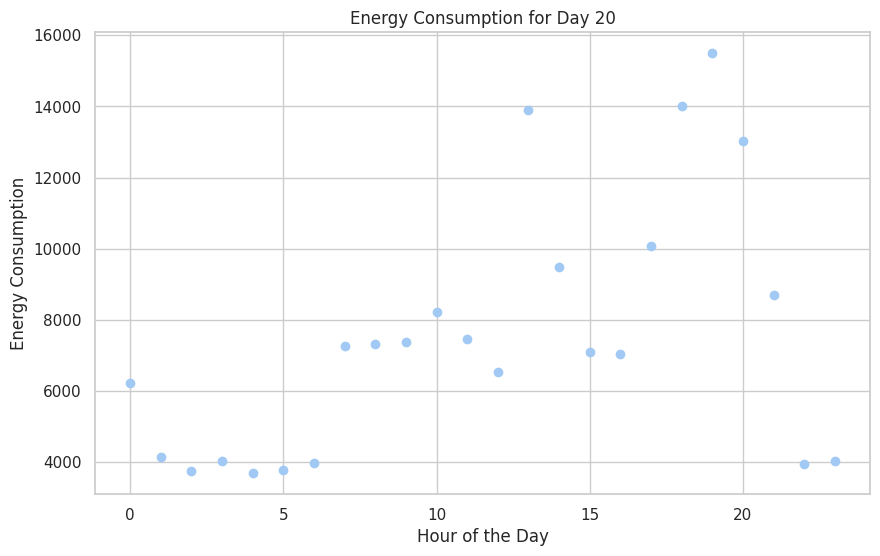

In [29]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(day_20_samples['hour'], day_20_samples['global_active_power'])
plt.title('Energy Consumption for Day 20')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()

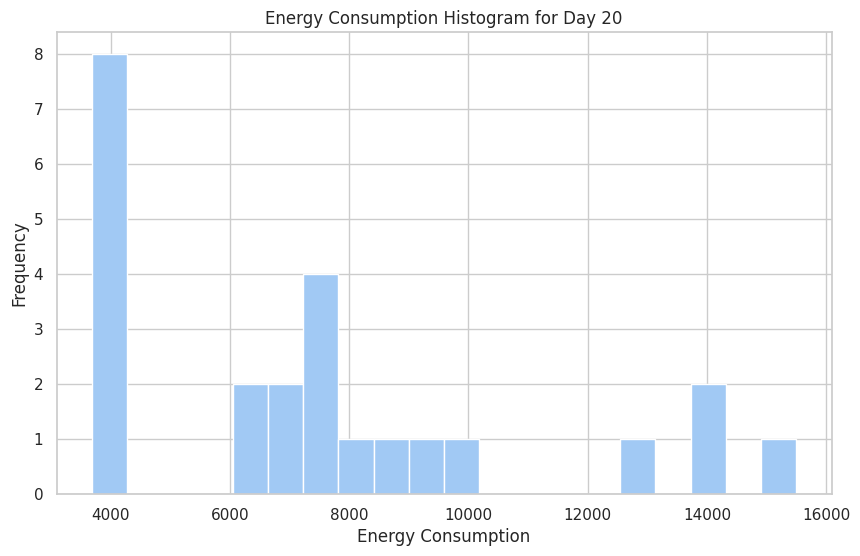

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(day_20_samples['global_active_power'], bins=20)  # Adjust the number of bins as needed
plt.title('Energy Consumption Histogram for Day 20')
plt.xlabel('Energy Consumption')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

(7522.237494337572, 3512.615603492305)  Kolmogorov-Smirnov test result: KstestResult(statistic=0.17235398213698333, pvalue=0.42605286626423833, statistic_location=7472.16, statistic_sign=1)


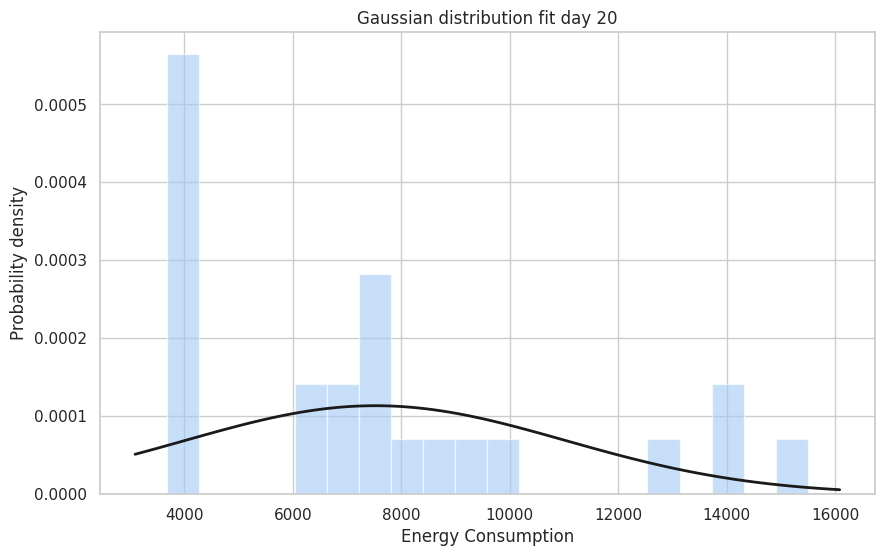

In [33]:
# Fit a Gaussian distribution to the data
mu, std = norm.fit(day_20_samples['global_active_power'])

# Create a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(day_20_samples['global_active_power'], bins=20, density=True, alpha=0.6)

# Plot the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add a title and labels
plt.title('Gaussian distribution fit day 20')
plt.xlabel('Energy Consumption')
plt.ylabel('Probability density')

# Perform Kolmogorov-Smirnov test
kstest_result = kstest(day_20_samples['global_active_power'], 'norm', args=(mu, std))
print(f"({mu}, {std})  Kolmogorov-Smirnov test result: {kstest_result}")

plt.show()

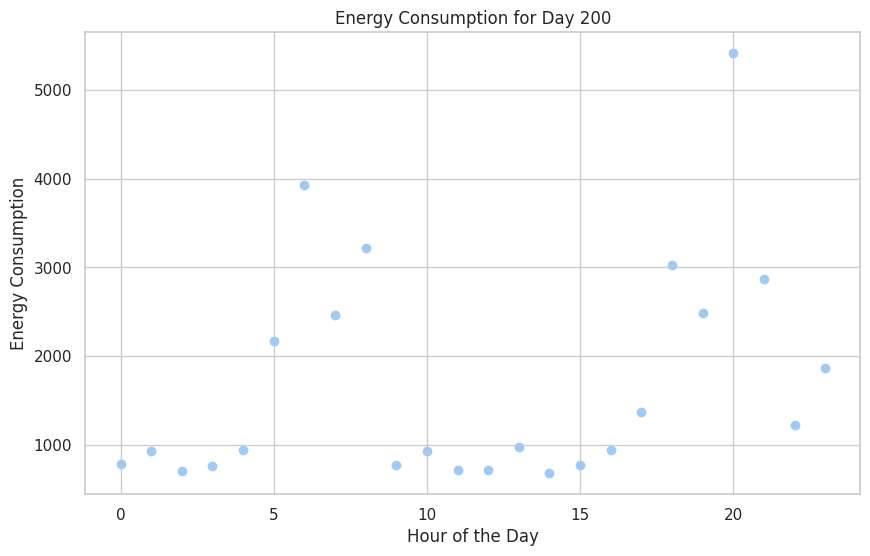

In [34]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(day_200_samples['hour'], day_200_samples['global_active_power'])
plt.title('Energy Consumption for Day 200')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()

(1694.7150000000001, 1231.2229402407186)  Kolmogorov-Smirnov test result: KstestResult(statistic=0.26273391888102865, pvalue=0.05964796429090269, statistic_location=973.1999999999999, statistic_sign=1)


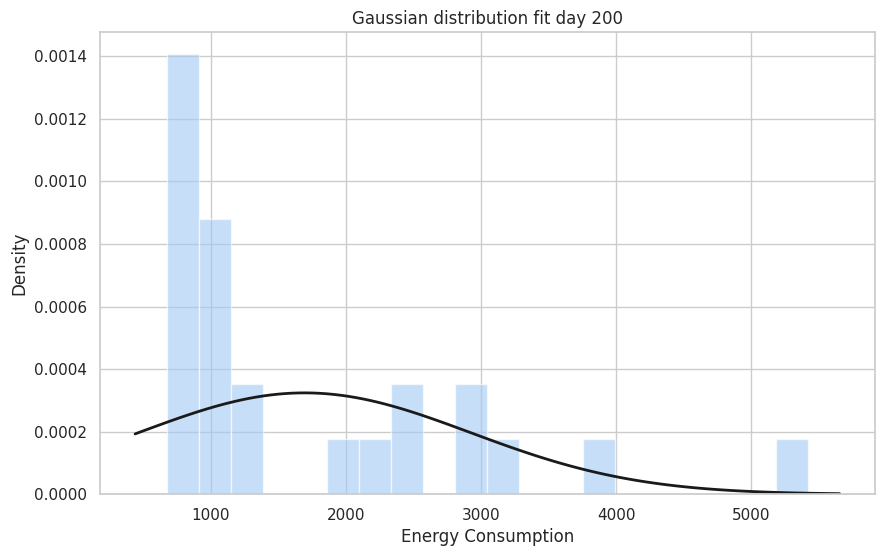

In [36]:
# Fit a Gaussian distribution to the data
mu, std = norm.fit(day_200_samples['global_active_power'])

# Create a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(day_200_samples['global_active_power'], bins=20, density=True, alpha=0.6)

# Plot the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add a title and labels
plt.title('Gaussian distribution fit day 200')
plt.xlabel('Energy Consumption')
plt.ylabel('Density')

# Perform Kolmogorov-Smirnov test
kstest_result = kstest(day_200_samples['global_active_power'], 'norm', args=(mu, std))
print(f"({mu}, {std})  Kolmogorov-Smirnov test result: {kstest_result}")

plt.show()

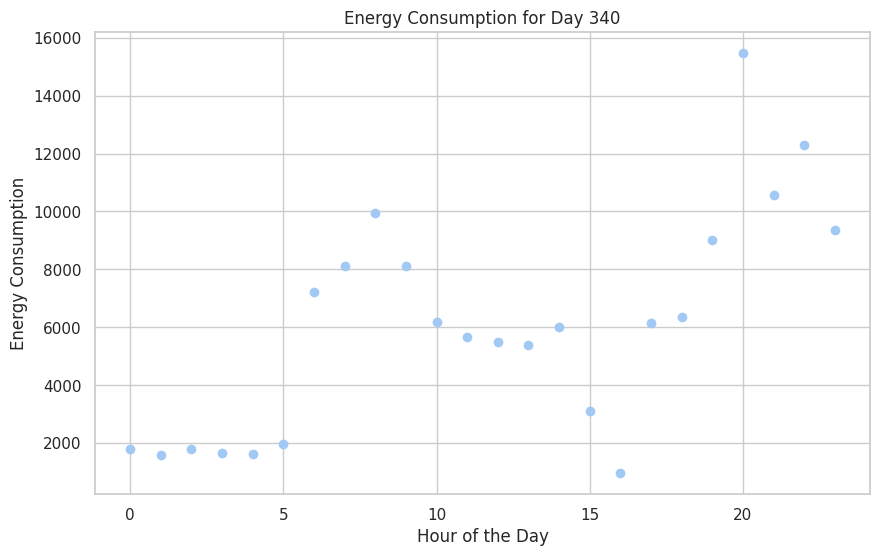

In [37]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(day_340_samples['hour'], day_340_samples['global_active_power'])
plt.title('Energy Consumption for Day 340')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()

(6082.195021853829, 3760.4528863104847)  Kolmogorov-Smirnov test result: KstestResult(statistic=0.15467632243715812, pvalue=0.5619328150523923, statistic_location=1968.48, statistic_sign=1)


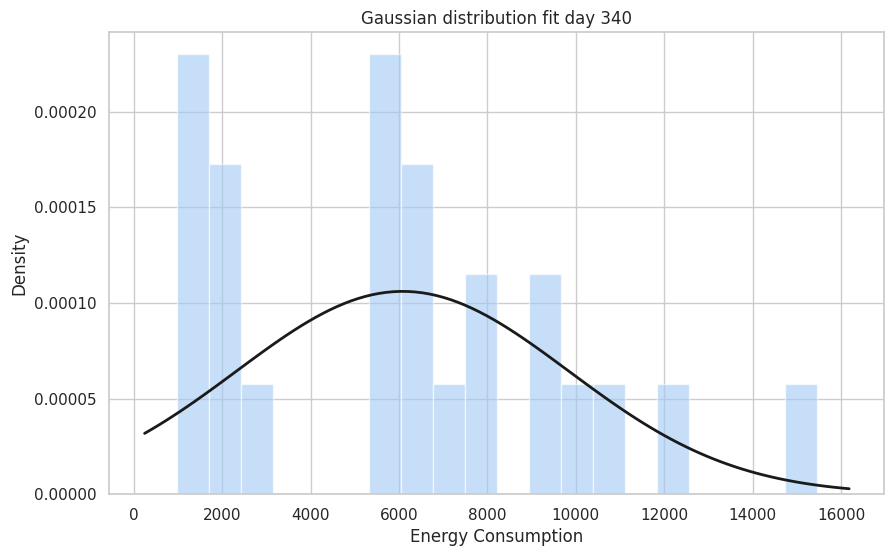

In [38]:
# Fit a Gaussian distribution to the data
mu, std = norm.fit(day_340_samples['global_active_power'])

# Create a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(day_340_samples['global_active_power'], bins=20, density=True, alpha=0.6)

# Plot the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add a title and labels
plt.title('Gaussian distribution fit day 340')
plt.xlabel('Energy Consumption')
plt.ylabel('Density')

# Perform Kolmogorov-Smirnov test
kstest_result = kstest(day_340_samples['global_active_power'], 'norm', args=(mu, std))
print(f"({mu}, {std})  Kolmogorov-Smirnov test result: {kstest_result}")

plt.show()

<h2 align="center"> <font color='gray'>Task 4: Using station data to predict energy consumption</font></h2> <a class="anchor" id="4"></a>

In [44]:
# Print the entire DataFrame
print(df_station.to_string(index=False))

               date     pmer      tend  cod_tend       dd       ff        t       td        u        vv       ww      w1       w2        n     nbas     hbas       cl       cm        ch      pres     tn12     tx12   tminsol     raf10   rafper   per  etat_sol  ht_neige  ssfrai  perssfrai      rr1      rr3      rr6     rr12     rr24  phenspe1  phenspe2  phenspe3  phenspe4  nnuage1   ctype1  hnuage1  nnuage2   ctype2   hnuage2  nnuage3   ctype3   hnuage3  nnuage4   ctype4   hnuage4
2007-01-01 00:00:00 0.999957 -1.013631  0.414674 0.160009 0.726021 0.999957 2.041831 1.352699 -0.999957 0.000000 1.56584 1.000000 0.326348 0.543476 2.318979 0.999957 0.999957 -0.999957 -0.999957 2.042424 0.999957 -0.999957 -0.999957 0.368341 -10.0  2.000000  0.000000 0.00000  -0.999957 0.000000 1.000000 5.000000 4.291556 2.637274  4.881953 -0.999957  0.999957  0.999957 0.817763 0.392946 2.445442 0.065495 0.568433 -0.999957 0.031132 0.659162 -0.999957 2.577776 0.000000 -0.999957
2007-01-01 03:00:00 0.999957  1.02

In [46]:
hourly_energy_consumption = df_household[['date', 'global_active_power']]

hourly_energy_consumption.set_index('date', inplace=True)

hourly_energy_consumption = hourly_energy_consumption.resample('3H').sum()
hourly_energy_consumption *= 60 # we convert power to energy in kJ

# Reset the index to move 'date' back into a regular column
hourly_energy_consumption.reset_index(inplace=True)


# Print or use the structured array
print(hourly_energy_consumption)

                     date  global_active_power
0     2007-01-01 00:00:00             27408.12
1     2007-01-01 03:00:00             26977.08
2     2007-01-01 06:00:00             26441.04
3     2007-01-01 09:00:00             30181.92
4     2007-01-01 12:00:00             21861.60
...                   ...                  ...
11403 2010-11-26 09:00:00             16349.88
11404 2010-11-26 12:00:00             16239.24
11405 2010-11-26 15:00:00             13212.96
11406 2010-11-26 18:00:00             15827.40
11407 2010-11-26 21:00:00               168.24

[11408 rows x 2 columns]


In [115]:
x_train = df_station[(df_station['date'].dt.year <= 2009)] # Station data for training
x_test = df_station[(df_station['date'].dt.year == 2010)] # Station data for testing
x_test = x_test[x_test['date'] <= '2010-11-26']

# Split the dataframe into two based on the years
y_train = hourly_energy_consumption[(hourly_energy_consumption['date'].dt.year >= 2007) & (hourly_energy_consumption['date'].dt.year <= 2009)]
y_test = hourly_energy_consumption[hourly_energy_consumption['date'].dt.year == 2010]

df_train = pd.merge_asof(x_train, y_train)
df_test = pd.merge_asof(x_test, y_test)

x_train = df_train.drop(columns=['global_active_power'])
y_train = df_train[['date', 'global_active_power']]

x_test = df_test.drop(columns=['global_active_power'])
y_test = df_test[['date', 'global_active_power']]


Let's check that dates match and that dataframes all have the same size.

In [116]:
x_train

date      pmer      tend  cod_tend        dd        ff  \
0    2007-01-01 00:00:00  0.999957 -1.013631  0.414674  0.160009  0.726021   
1    2007-01-01 03:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
2    2007-01-01 06:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
3    2007-01-01 09:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
4    2007-01-01 12:00:00  0.999957  1.024979  0.000000  0.160009  0.726021   
...                  ...       ...       ...       ...       ...       ...   
8746 2009-12-31 09:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
8747 2009-12-31 12:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
8748 2009-12-31 15:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
8749 2009-12-31 18:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
8750 2009-12-31 21:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   

             t        td         u        vv  ...   hnuage1   nnuage2  \
0     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
1     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
2     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
3     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
4     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
...        ...       ...       ...       ...  ...       ...       ...   
8746  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
8747  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
8748  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
8749  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
8750  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   

        ctype2   hnuage2   nnuage3    ctype3   hnuage3   nnuage4    ctype4  \
0     0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.000000   
1     0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.000000   
2     0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.000000   
3     0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.000000   
4     0.000000 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
8746  0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
8747  0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
8748  0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
8749  0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
8750  0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   

       hnuage4  
0    -0.999957  
1    -0.999957  
2    -0.999957  
3    -0.999957  
4    -0.999957  
...        ...  
8746 -0.999957  
8747 -0.999957  
8748 -0.999957  
8749 -0.999957  
8750 -0.999957  

[8751 rows x 51 columns]

In [117]:
y_train

date  global_active_power
0    2007-01-01 00:00:00         27408.120000
1    2007-01-01 03:00:00         26977.080000
2    2007-01-01 06:00:00         26441.040000
3    2007-01-01 09:00:00         30181.920000
4    2007-01-01 12:00:00         21861.600000
...                  ...                  ...
8746 2009-12-31 09:00:00         20006.160000
8747 2009-12-31 12:00:00         18231.748747
8748 2009-12-31 15:00:00         17087.160000
8749 2009-12-31 18:00:00         31943.640000
8750 2009-12-31 21:00:00         23760.840000

[8751 rows x 2 columns]

In [118]:
x_test

date      pmer      tend  cod_tend        dd        ff  \
0    2010-01-01 00:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
1    2010-01-01 03:00:00  0.999957 -1.013631  0.414674  0.160009  0.726021   
2    2010-01-01 06:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
3    2010-01-01 09:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
4    2010-01-01 12:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
...                  ...       ...       ...       ...       ...       ...   
2615 2010-11-25 09:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
2616 2010-11-25 12:00:00  0.999957 -1.013631  0.414674  0.160009  0.726021   
2617 2010-11-25 15:00:00  0.999957 -1.013631  0.414674  0.160009  0.726021   
2618 2010-11-25 18:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   
2619 2010-11-26 00:00:00  0.999957  1.024979  0.414674  0.160009  0.726021   

             t        td         u        vv  ...   hnuage1   nnuage2  \
0     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
1     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
2     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
3     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
4     0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
...        ...       ...       ...       ...  ...       ...       ...   
2615  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
2616  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
2617  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
2618  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   
2619  0.999957  2.041831  1.352699 -0.999957  ...  2.445442  0.065495   

        ctype2   hnuage2   nnuage3    ctype3   hnuage3   nnuage4    ctype4  \
0     0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
1     0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
2     0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
3     0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
4     0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
...        ...       ...       ...       ...       ...       ...       ...   
2615  0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
2616  0.568433 -0.999957  0.031132  0.000000 -0.999957  2.577776  0.299471   
2617  0.568433 -0.999957  0.031132  0.000000 -0.999957  2.577776  0.299471   
2618  0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   
2619  0.568433 -0.999957  0.031132  0.659162 -0.999957  2.577776  0.299471   

       hnuage4  
0    -0.999957  
1    -0.999957  
2    -0.999957  
3    -0.999957  
4    -0.999957  
...        ...  
2615 -0.999957  
2616 -0.999957  
2617 -0.999957  
2618 -0.999957  
2619 -0.999957  

[2620 rows x 51 columns]

In [119]:
y_test

date  global_active_power
0    2010-01-01 00:00:00              8430.72
1    2010-01-01 03:00:00              6938.88
2    2010-01-01 06:00:00              6781.32
3    2010-01-01 09:00:00             10484.88
4    2010-01-01 12:00:00             13734.48
...                  ...                  ...
2615 2010-11-25 09:00:00             10552.44
2616 2010-11-25 12:00:00              4163.88
2617 2010-11-25 15:00:00              8477.64
2618 2010-11-25 18:00:00             22283.64
2619 2010-11-26 00:00:00              3055.44

[2620 rows x 2 columns]

In [120]:
#before we start training, let's drop the date column. It has already served its purpose :)
x_train = x_train.drop('date', axis=1)
x_test = x_test.drop('date', axis=1)
y_train = y_train.drop('date', axis=1)
y_test = y_test.drop('date', axis=1)

In [135]:
# Random Forest Regression
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(x_train, y_train)
random_forest_predictions = random_forest_reg.predict(x_test)
random_forest_rmse = mean_squared_error(y_test, random_forest_predictions, squared=False)
print("Random Forest Regression RMSE:", random_forest_rmse)

# Gradient Boosting Regression
gradient_boosting_reg = GradientBoostingRegressor()
gradient_boosting_reg.fit(x_train, y_train)
gradient_boosting_predictions = gradient_boosting_reg.predict(x_test)
gradient_boosting_rmse = mean_squared_error(y_test, gradient_boosting_predictions, squared=False)
print("Gradient Boosting Regression RMSE:", gradient_boosting_rmse)

# Feature Importances

# Random Forest Feature Importance
random_forest_feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                                  'Importance': random_forest_reg.feature_importances_})
random_forest_feature_importances = random_forest_feature_importances.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:")
print(random_forest_feature_importances.head(10))  # Display top 10 features

# Gradient Boosting Feature Importance
gradient_boosting_feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                                      'Importance': gradient_boosting_reg.feature_importances_})
gradient_boosting_feature_importances = gradient_boosting_feature_importances.sort_values(by='Importance', ascending=False)
print("Gradient Boosting Feature Importances:")
print(gradient_boosting_feature_importances.head(10))  # Display top 10 features

/home/gabriel/.local/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Regression RMSE: 7284.119864353626


/home/gabriel/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gradient Boosting Regression RMSE: 6749.1320476059245
Random Forest Feature Importances:
     Feature  Importance
33      rr24    0.190920
25  etat_sol    0.144903
32      rr12    0.129627
31       rr6    0.122634
45    ctype3    0.055209
1       tend    0.043987
11        w2    0.040767
42    ctype2    0.038995
48    ctype4    0.038054
30       rr3    0.036395
Gradient Boosting Feature Importances:
     Feature  Importance
25  etat_sol    0.292453
32      rr12    0.150750
1       tend    0.133651
48    ctype4    0.109710
33      rr24    0.088593
31       rr6    0.072265
30       rr3    0.030567
11        w2    0.023846
45    ctype3    0.020823
12         n    0.018048


In [139]:
# Convert 2D arrays to 1D arrays
y_test = np.squeeze(y_test)
random_forest_predictions = np.squeeze(random_forest_predictions)
gradient_boosting_predictions = np.squeeze(gradient_boosting_predictions)

# Side-by-Side Comparison
comparison_df = pd.DataFrame({'y_test': y_test, 
                              'RandomForest_Predictions': random_forest_predictions, 
                              'GradientBoosting_Predictions': gradient_boosting_predictions})
print(comparison_df)  # Display first 10 rows of comparison


        y_test  RandomForest_Predictions  GradientBoosting_Predictions
0      8430.72              15393.536143                  15724.675709
1      6938.88               8423.300005                   9031.194162
2      6781.32              13516.185346                  13270.849730
3     10484.88              13516.185346                  13270.849730
4     13734.48              12585.506078                  13275.130743
...        ...                       ...                           ...
2615  10552.44              16393.049232                  14427.296127
2616   4163.88              14320.935977                  11044.466603
2617   8477.64              16987.010574                  12019.338100
2618  22283.64              14113.534924                  13614.774117
2619   3055.44              16283.063135                  12851.491706

[2620 rows x 3 columns]


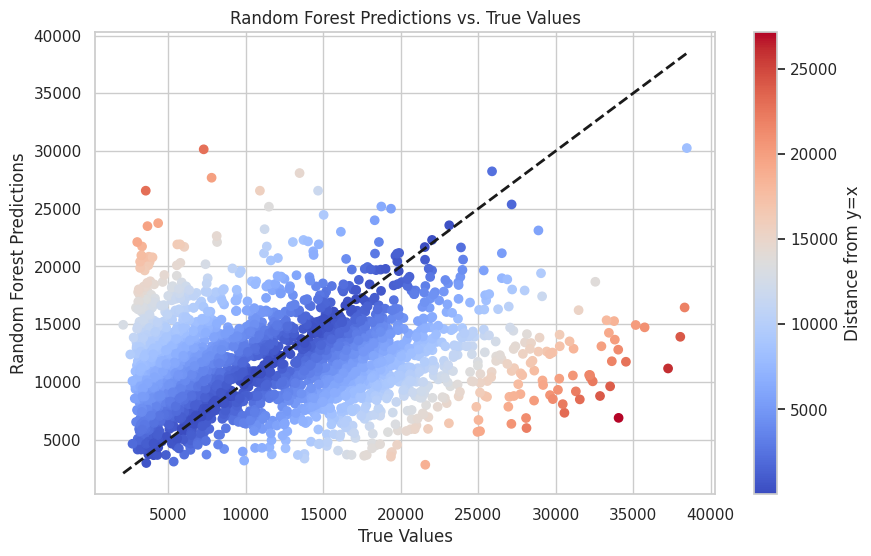

In [141]:
# Scatter Plot for Random Forest Regression
plt.figure(figsize=(10, 6))

# Plot y = x line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)

# Plot Random Forest predictions vs. y_test
plt.scatter(y_test, random_forest_predictions, c=np.abs(random_forest_predictions - y_test), cmap='coolwarm')
plt.colorbar(label='Distance from y=x')
plt.xlabel('True Values')
plt.ylabel('Random Forest Predictions')
plt.title('Random Forest Predictions vs. True Values')
plt.show()


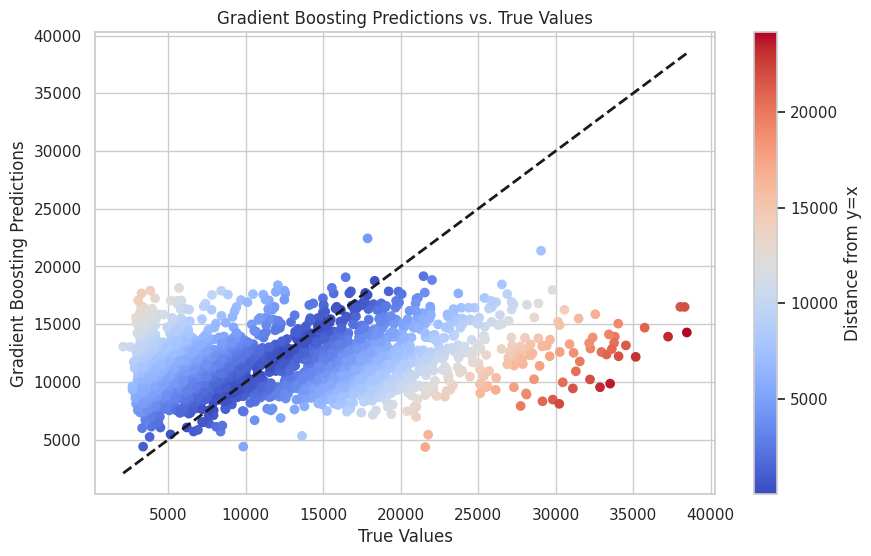

In [142]:
# Scatter Plot for Gradient Boosting Regression
plt.figure(figsize=(10, 6))

# Plot y = x line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)

# Plot Gradient Boosting predictions vs. y_test
plt.scatter(y_test, gradient_boosting_predictions, c=np.abs(gradient_boosting_predictions - y_test), cmap='coolwarm')
plt.colorbar(label='Distance from y=x')
plt.xlabel('True Values')
plt.ylabel('Gradient Boosting Predictions')
plt.title('Gradient Boosting Predictions vs. True Values')
plt.show()


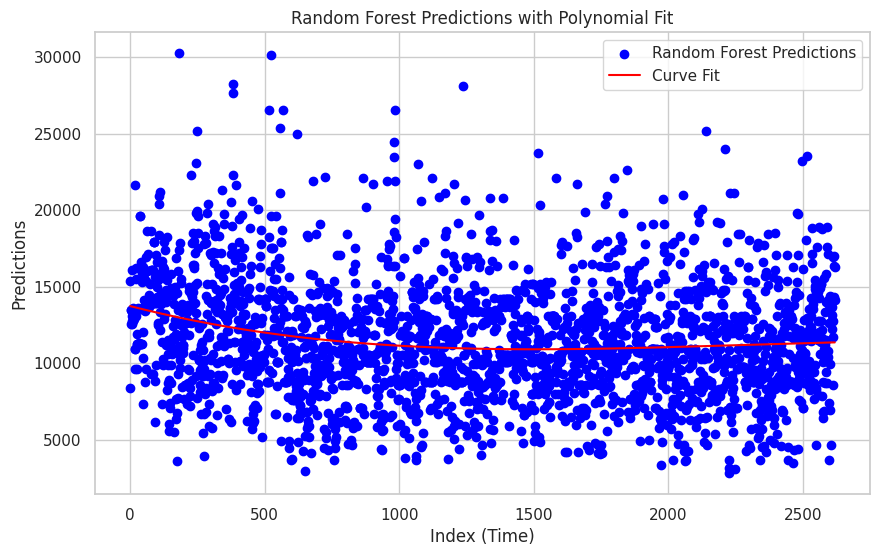

In [147]:
# Fit a curve over Random Forest Regression Predictions
coefficients_rf = np.polyfit(range(len(y_test)), random_forest_predictions, 3)
polynomial_rf = np.poly1d(coefficients_rf)

# Scatter Plot with Curve for Random Forest Regression Predictions over Time
plt.figure(figsize=(10, 6))

# Plot index vs. Random Forest predictions
plt.scatter(range(len(y_test)), random_forest_predictions, c='blue', label='Random Forest Predictions')

# Plot fitted curve
plt.plot(range(len(y_test)), polynomial_rf(range(len(y_test))), color='red', label='Polynomial Fit')

plt.xlabel('Index (Time)')
plt.ylabel('Predictions')
plt.title('Random Forest Predictions with Polynomial Fit')
plt.legend()
plt.show()


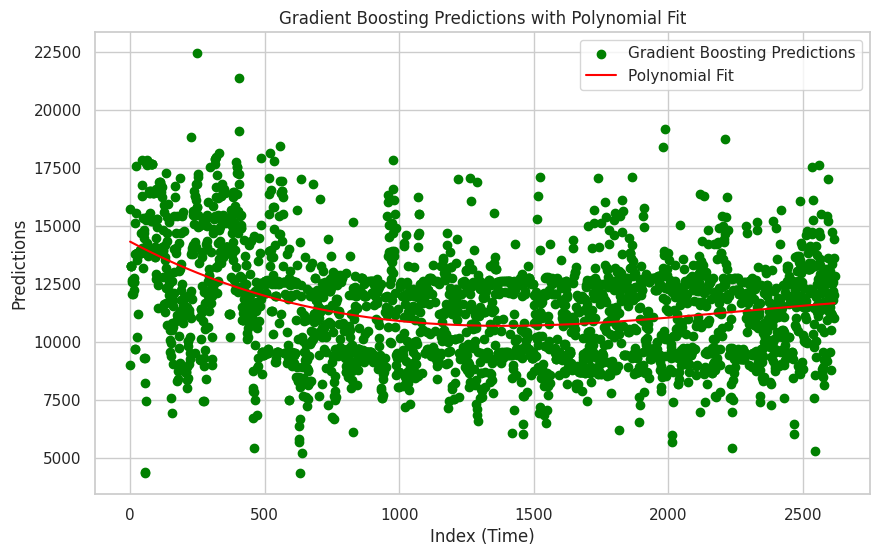

In [148]:
# Fit a curve over Gradient Boosting Regression Predictions
coefficients_gb = np.polyfit(range(len(y_test)), gradient_boosting_predictions, 3)
polynomial_gb = np.poly1d(coefficients_gb)

# Scatter Plot with Curve for Gradient Boosting Regression Predictions over Time
plt.figure(figsize=(10, 6))

# Plot index vs. Gradient Boosting predictions
plt.scatter(range(len(y_test)), gradient_boosting_predictions, c='green', label='Gradient Boosting Predictions')

# Plot fitted curve
plt.plot(range(len(y_test)), polynomial_gb(range(len(y_test))), color='red', label='Polynomial Fit')

plt.xlabel('Index (Time)')
plt.ylabel('Predictions')
plt.title('Gradient Boosting Predictions with Polynomial Fit')
plt.legend()
plt.show()
